# Masterclass Deep Learning 
## Introduction à la reconnaissance vocale 
### Introduction
La reconnaissance vocale a été l’une des tâches les plus difficiles de l’apprentissage automatique. Les approches traditionnelles impliquent la création et l'extraction méticuleuses des caractéristiques audio qui séparent un phonème d'un autre. Pour ce faire, il faut avoir une connaissance approfondie de la science des données et du traitement du signal.

Avec le développement croissant de Deep Learning, l'extraction artisanales des features n'était plus nécessaire. Le processus d'entraînement d'un réseau de neurones est beaucoup plus simple. Vous pouvez entraîner le modèle avec des signaux sous leur forme brute ou au fur et à mesure de leurs spectrogrammes et observer l'amélioration du modèle.

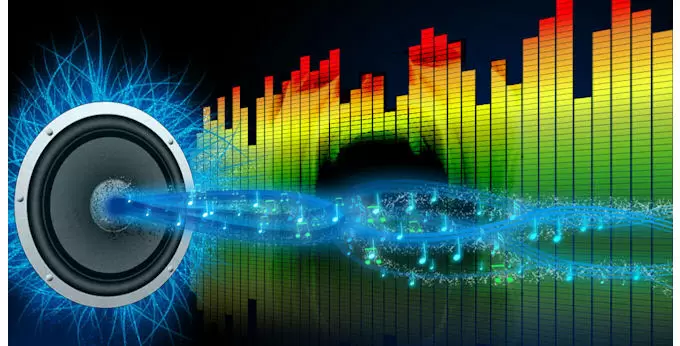

Voici un aperçu des étapes que nous allons parcourir :

- Visualisation et lecture d'un fichier audio
- Concepts fondamentaux : Fréquence d'échantillonnage, Spectrogramme, échelle mel ...
- Augmentation de données
- Parallèle avec la reconnaissance de l'écriture manuscrite.
- Fonction de coût : Connectionist Temporal Classification (CTC)
- Architecture du modèle
- Décodeur : Best path decoding et Beam search decoder
- Première évalation du modèle
- Modèle de langage.

### Visualisation et lecture d'un fichier Audio

Nous allons commencer ce module de reconnaissance vocale avec une introduction générale sur les concepts fondamentaux des données audio numérique en utilisant le jeu de données libriSpeech (le fichier à télécharger, environ 23 Go). Pour une question de puissance de calcul et de mémoire, nous n'utiliserons qu'un échantillon du jeu de données. Nous avons déjà appliqué un prétraitement sur le jeu de données en enlevant les échantillons avec des caractères d'autres langues, les fichiers inexistants et les ponctuations.

Charger le jeu de données libriSpeech.csv et faites un bref audit des données.  http://www.openslr.org/resources/12/train-clean-360.tar.gz  23Go !!! j'ai pris le test-clean de 331Mo !!!

In [ ]:
"""ne pas charger, il n'y a pas de csv dans mon jeu téléchargé dans data/sound/test-clean => voir SPEAKERS.TXT où tout semble être là """

import pandas as pd
df = pd.read_csv("libriSpeech.csv")
df.head()


audio_path	                                         text
0	LibriSpeech/32/4137/32-4137-0057.flac	the mantled treachery of his soul o where is h...
1	LibriSpeech/32/4137/32-4137-0012.flac	had a set of teeth which for whiteness and bea...
2	LibriSpeech/19/227/19-227-0024.flac	asked her if she would have the goodness to sh...
3	LibriSpeech/19/227/19-227-0049.flac	and thankful for mister thorpe's communication...
4	LibriSpeech/32/21634/32-21634-0018.flac	he added that johnnie green had a new gun on t...

Nous allons utiliser la bibliothèque librosa pour appliquer une succession de transformation à nos fichiers audios.

La fonction load de cette bibliothèque permet de charger un fichier audio (à l'exeption des fichiers mp3) sur le chemin défini en argument path. Elle retourne la liste des valeurs audio ainsi que la fréquence d'échantillonnage fe .

Charger le premier fichier audio de df à l'aide de la fonction load_audio, et stocker le tableau de données et la fréquence d'échantillonnage sous le nom respectif audio et fe.

In [ ]:
import librosa
def load_audio(audio_path):
    return librosa.load(audio_path, sr=None)
audio, fe = load_audio(df.iloc[0,0])

In [ ]:
""" /home/ubuntu/virtualenvs/python3/lib/python3.6/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg) """ chez eux

La fonction Audio de IPython.display permet d'écouter un fichier audio data avec une fréquence d'échantillonnage rate.

Ecouter le fichier audio en utilisant la fonction Audio.

In [ ]:
from IPython.display import Audio
Audio(audio, rate=fe)

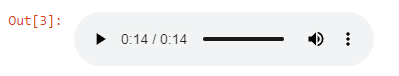

In [ ]:
Afficher la transcription de ce fichier audio.

In [ ]:
 'the mantled treachery of his soul o where is he who hath surveyed the horrors of our own slave trade there is an eye that wakes in light there is a hand of peerless might which soon or late'

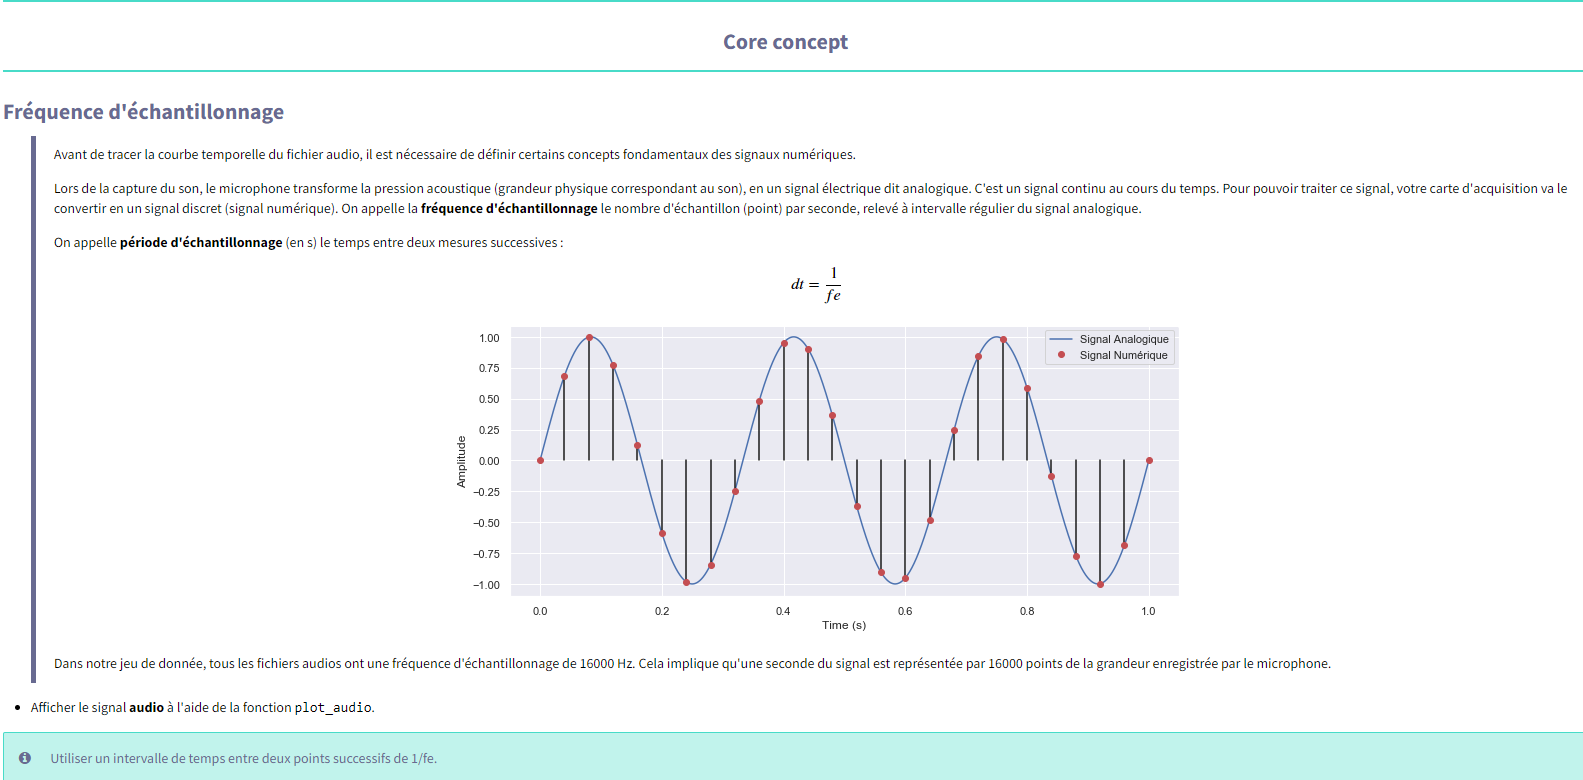

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_audio(audio_data, fe):
    # Intervalle de temps entre deux points.
    dt= 1/fe 
    # Variable de temps en seconde.
    t = dt*np.arange(len(audio_data)) 
    plt.plot(t, audio_data)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.figure(figsize=(10,5))
plot_audio(audio, fe)

Le Théorème de Shanon énonce qu'un échantillonnage à la fréquence d'échantillonnage  fefe  ne peut transmettre sans perte d'information que des fréquences inférieures à  Fe2Fe2 . Plus simplement, la fréquence d'échantillonnage  fefe  doit être au moins deux fois plus importante que la fréquence maximale du signal analogique.

Exécuter la cellule suivante pour observer les phénomènes d'intermodulation (fréquence d'échantillonnage trop faible).
   La fréquence du signal est de 3 Hz.

In [ ]:
from ipywidgets import interactive
import seaborn as sns
sns.set()
def sampling(fe):
    duration = 1 # Durée du signal
    f = 3 # Fréquence du signal
    t_real = duration/10000*np.arange(10000) # On utilisera une fréquence d'échantillonnage très importante pour simuler le signal analogique
    real_fonction = np.sin(2*np.pi*f*t_real)
    plt.figure(figsize=(10,5))
    plt.plot(t_real, real_fonction, label='Signal Analogique')
    
    t_s = duration/(fe-1)*np.arange(fe)
    sampling_fonction = np.sin(2*np.pi*f*t_s)
    # Plot the black line
    for i in range(len(t_s)):
        plt.plot([t_s[i], t_s[i]], [0, sampling_fonction[i]], '-k')
        
    plt.plot([-0, 1], [0, 0], '-k', alpha=0.5, linewidth=0.5)
    plt.plot(t_s, sampling_fonction,'r-o', label='Signal Numérique')
    plt.xlabel("Time (s)")
    plt.xlim([-0.05, 1.05])
    plt.ylabel("Amplitude")
    plt.legend()
    
interactive_plot = interactive(sampling, fe=(2, 50))

interactive_plot

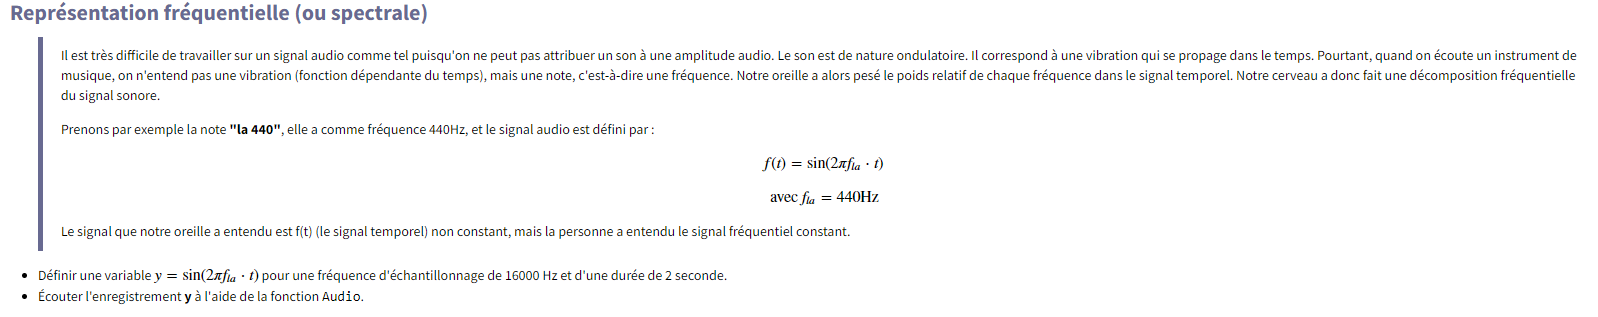

In [ ]:
fe = 16000 # Hz
f_la = 440 # Hz
t = 1/fe*np.arange(2*fe) # Time
y = np.sin(2*np.pi*f_la*t) # Audio Amplitude
Audio(y, rate=fe)

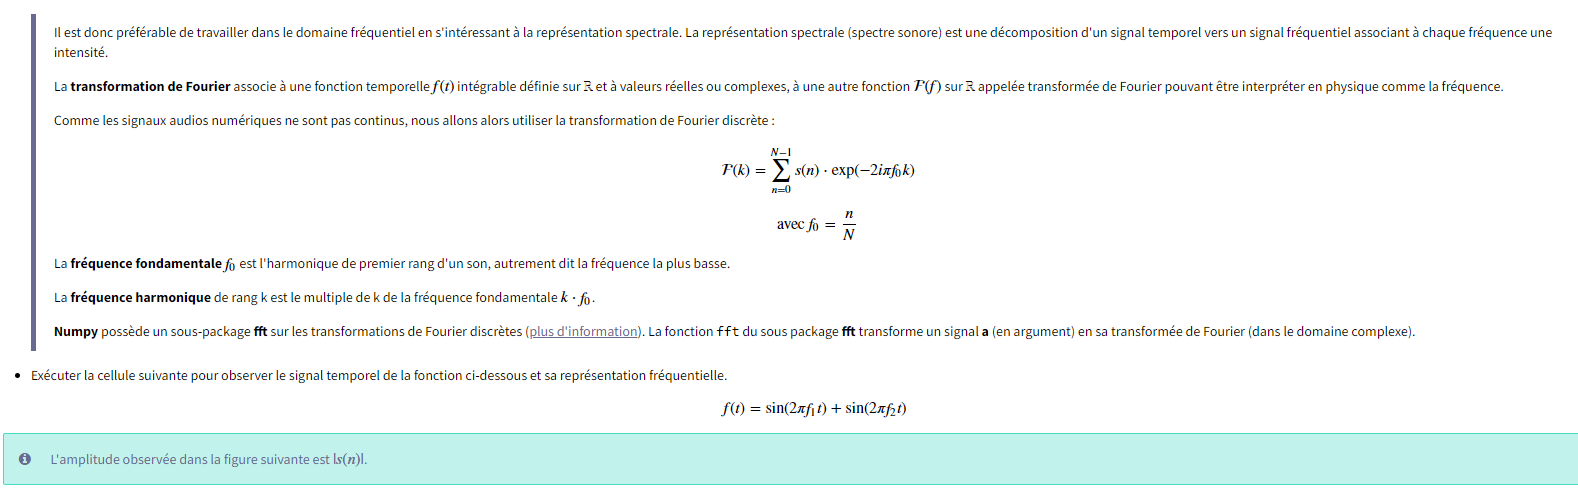

In [ ]:
def sampling(f1, f2):
    duration = 0.05 # seconde
    fe = 8000
    dt = 1/fe
    t = dt*np.arange(fe*duration)
    y = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)# sin(w*t)
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plot_audio(y, fe)
    plt.title("Temporal signal")
    plt.subplot(122)
    y_fourier = np.abs(np.fft.fft(y))[:len(y)//2]
    plt.bar(fe/(2*len(y_fourier))*np.arange(len(y_fourier)),y_fourier, edgecolor='b')
    plt.title("Frequency signal")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    
interactive_plot = interactive(sampling, f1=(100, 2000,100), f2=(100, 2000,100))
interactive_plot

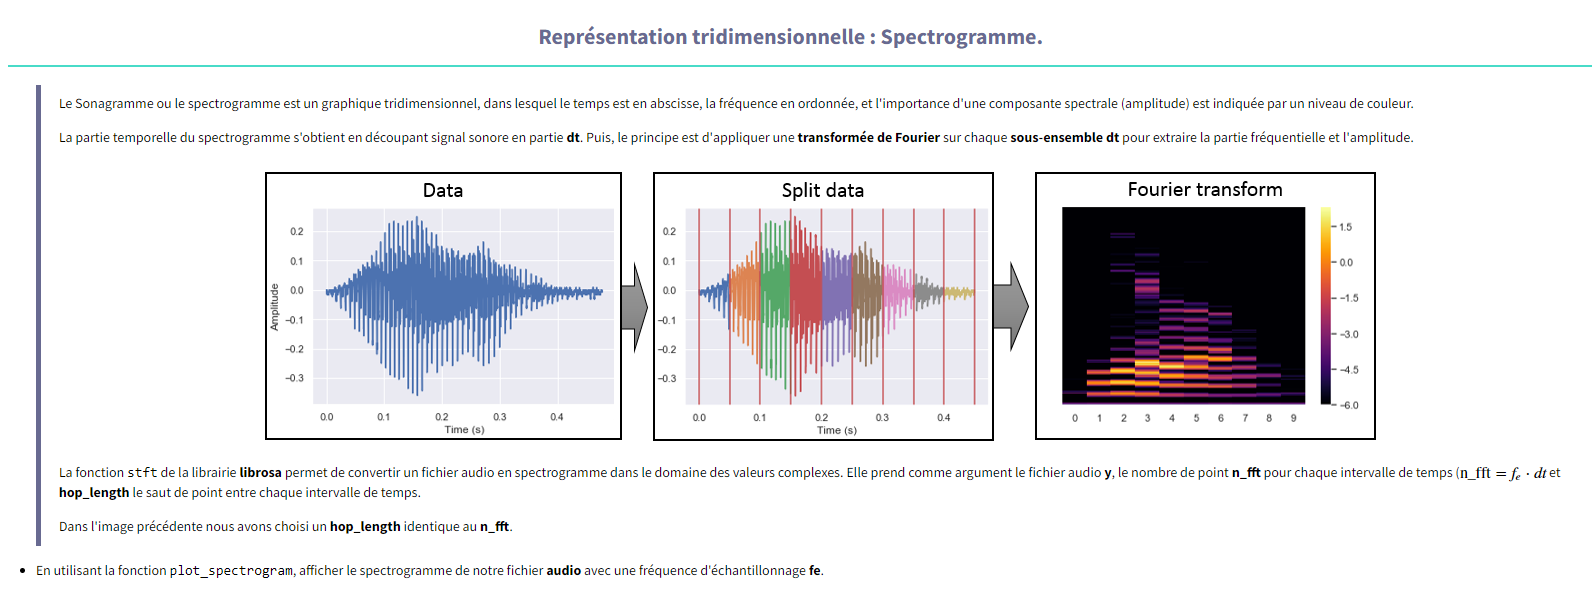

In [ ]:
import librosa
import seaborn as sns

def spectrogram(audio, fe, dt):
    return np.abs(librosa.stft(audio,
                        n_fft = int(dt*fe),
                        hop_length = int(dt*fe/2)
                        )
                 )

def plot_spectrogram(audio, fe, dt=0.02):
    im = spectrogram(audio, fe, dt)
    sns.heatmap(np.rot90(im.T), cmap='inferno', vmin=0, vmax=np.max(im)/3)
    loc, labels = plt.xticks()
    l = np.round((loc-loc.min())*len(audio)/fe/loc.max(), 2)
    plt.xticks(loc, l)
    loc, labels = plt.yticks()
    l = np.array(loc[::-1]*fe/2/loc.max(), dtype=int)
    plt.yticks(loc, l)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")

plt.figure(figsize=(15,5))
plot_spectrogram(audio, fe)

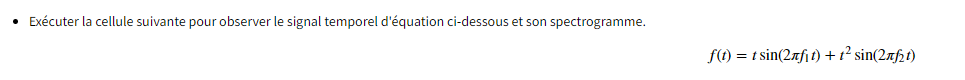

In [ ]:
def sampling(f1, f2, dt):
    fe = 16000
    duration = 0.25 #seconde
    t = np.arange(fe*duration)/fe
    y = t*np.sin(2*np.pi*f1*t) + t**2*np.sin(2*np.pi*f2*t)# sin(w*t)
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plot_audio(y, fe)
    for i in range(int(duration//dt)+1):
        plt.axvline(x=i*dt, color='r', linestyle='-')
    plt.subplot(122)
    plot_spectrogram(y, fe, dt=dt)
    
interactive_plot = interactive(sampling, f1=(100, 2000, 100), f2=(100, 500, 100), dt=(0.02,0.10,0.01))

interactive_plot

In [ ]:
Exécuter la cellule suivante pour observer le signal temporel de notre fichier audio et son spectrogramme.

In [ ]:
def sampling(dt):
    duration = len(audio)/fe
    t = np.arange(fe*duration)/fe
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plot_audio(audio, fe)
    for i in range(int(duration//dt)+1):
        plt.axvline(x=i*dt, color='r', linestyle='-')
    plt.subplot(122)
    plot_spectrogram(audio, fe, dt=dt)
    
interactive_plot = interactive(sampling, dt=(0.01,0.10,0.01))

interactive_plot

## LogMelSpectrogram

La perception auditive n'est pas la même pour une variation fréquentielle dans les basses fréquences par rapport aux hautes fréquences. L'échelle de Mel est une échelle de fréquences conçue pour qu'une variation constante dans le domaine des mels soit perçue comme une variation constante de fréquence (en Hz) par les auditeurs.

Prenons par exemple une fréquence de base de 1000Hz. Un son à 2000Hz ne sera pas perçu par un auditeur comme étant 2 fois supérieur à la fréquence de base.

Par contre, si on effectue le changement fréquentiel dans le domaine des mels, 1000Hz correspondent à 1000mels. Un son à 2000 mels, c'est-à-dire à 3428Hz, sera perçu comme étant deux fois plus aigu qu'un son à 1000Hz.

Exécuter la cellule suivante pour afficher le log du spectrogramme dans l'échelle mel.

In [ ]:
params = {
    'n_fft': 160*16,
    'frame_step': 160*8,
    'lower_edge_hertz': 0,
    'upper_edge_hertz': 8000,
    'num_mel_bins': 160
}

def logMelSpectrogram(audio, params, fe):

    stfts = librosa.stft(audio,
                        n_fft = int(params['n_fft']),
                        hop_length = int(params["frame_step"]),
                        center = False
                        ).T
    power_spectrograms = np.real(stfts * np.conj(stfts))


    linear_to_mel_weight_matrix = librosa.filters.mel(
                                sr=fe,
                                n_fft=int(params['n_fft']) + 1,
                                n_mels=params['num_mel_bins'],
                                fmin=params['lower_edge_hertz'],
                                fmax=params['upper_edge_hertz']
                    ).T

    mel_spectrograms = np.tensordot(
                power_spectrograms,
                linear_to_mel_weight_matrix,
                1
            )

    return (np.log(mel_spectrograms + 1e-8).astype(np.float16))


def plot_logMelSpectrogram(audio, params, fe):
    sns.heatmap(np.rot90(logMelSpectrogram(audio, params, fe)), cmap='inferno', vmin = -6)
    loc, labels = plt.xticks()
    l = np.round((loc-loc.min())*len(audio)/fe/loc.max(), 2)
    plt.xticks(loc, l)
    plt.yticks([])
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Mel)")
    
    
plt.figure(figsize=(20,5))
plot_logMelSpectrogram(audio, params, fe)

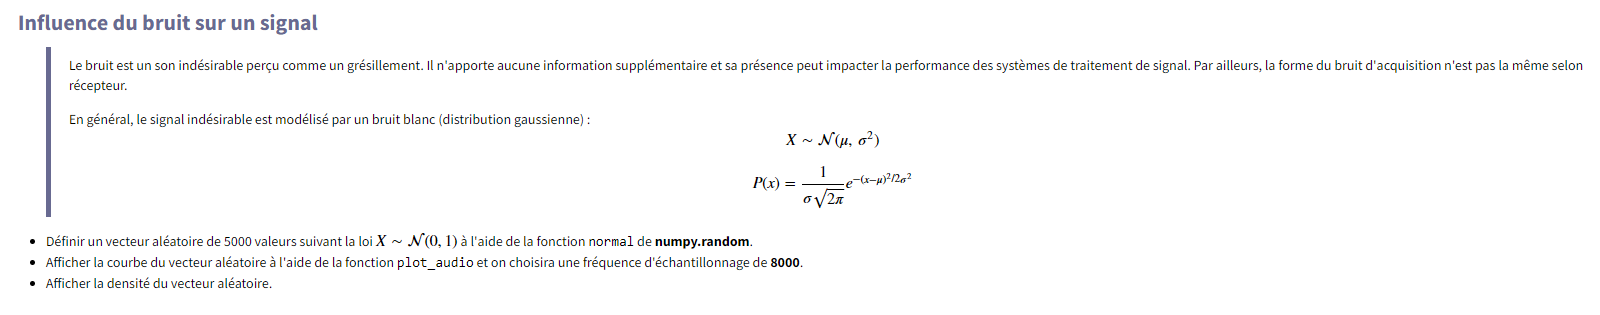

In [ ]:
noise_audio = np.random.normal(0,1,5000) # noise signal
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Audio Signal')
plot_audio(noise_audio, fe) # plot noise signal
plt.subplot(122)
plt.title('Density')
plt.xlabel('Amplitude')
plt.ylabel('Density probabilité')
sns.distplot(noise_audio) # plot distribution of signal
plt.show();

Dans la partie précédente, nous avons introduit le concept de bruit. Nous allons maintenant chercher à ajouter un bruit blanc à un fichier audio afin d'observer l'impact sur la qualité du son et sur le spectrogramme.

Comme les fichiers audios n'ont pas été acquis par les mêmes récepteurs, ils n'auront pas tous la même échelle de valeur. C'est pourquoi nous allons choisir de modéliser l'écart-type du bruit par rapport à la valeur maximale de l'échantillon.

Exécuter la cellule suivante pour afficher l'influence du bruit sur le signal et le spectrogramme.

In [ ]:
def random_noise(audio, rate):
    noises = np.random.normal(0,np.max(np.abs(audio))*rate, len(audio))
    return np.array(audio + noises)

# Audio file 0
audio, fe = load_audio(df.audio_path[0])
audio_noise = random_noise(audio, rate=0.05)

plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
plt.title("Audio")
plot_audio(audio, fe)
plt.subplot(2, 2, 2)
plt.title("Spectre audio")
plot_logMelSpectrogram(audio, params, fe)
plt.subplot(2, 2, 3)
plt.title("Audio with noise")
plot_audio(audio_noise, fe)
plt.subplot(2, 2, 4)
plt.title("Spectre with noise")
plot_logMelSpectrogram(audio_noise, params, fe)
plt.show();

On peut remarquer une propriété importante du bruit blanc, sa distribution fréquentielle est uniforme sur le spectre.

Exécuter cette cellule pour écouter le signal bruité.

## Augmentation de données : Génération de nouvelles données
L'un des meilleurs moyens pour éviter les phénomènes de sur-apprentissage et donc d'améliorer les performances d'un modèle de Deeplearning consiste à ajouter davantage de données à l'ensemble d'entraînement.

Dans le cadre des images, la génération de nouvelles données peuvent être faite en appliquant des transformations géométriques sur nos images (zoom, redimensionnement, changement de la luminosité ...). La fonction ImageDataGenerator de la bibliothèque keras permet d'appliquer tout un ensemble de transformation sur les images de base (plus d'informations). https://keras.io/api/preprocessing/image/

Dans le cadre des signaux audio, nous pouvons appliquer les transformations suivantes à nos fichiers audio :

Étirement du temps à l'aide de la fonction time_stretch de librosa.effects.
Décalage temporel aléatoire à l'aide de la fonction pad de numpy.
Appliquer des bruits en superposant nos fichiers audio avec des bruits enregistrés (ou à un bruit blanc).

## Ce qu'il faut retenir de cette partie
Pour pouvoir traiter un signal audio, il est nécessaire convertir le signal analogique (continue) en un signal numérique (discret). On appelle la fréquence d'échantillonnage le nombre d'échantillon (point) par seconde relevé à intervalle régulier du signal analogique.

Il est très difficile de travailler sur un signal audio comme tel puisqu'on ne peut pas attribuer un son à une amplitude audio. Il est plus pertinant de décomposer le signal temporelle sous forme d'un signal fréquentielle pour extraire l'ensemble des notes du son. Si nous applicons la fft (Fast Fourier Transform) sur l'ensemble du signal, nous perdons l'information sur la succession des notes (ou des sons), c'est pourquoi, il est préférable d'extraire le spectrogramme de notre signal.

Le Sonagramme ou le spectrogramme est un graphique tridimensionnel, dans lesquel le temps est en abscisse, la fréquence en ordonnée, et l'importance d'une composante spectrale (amplitude) est indiquée par un niveau de couleur. Il peut être vue comme une

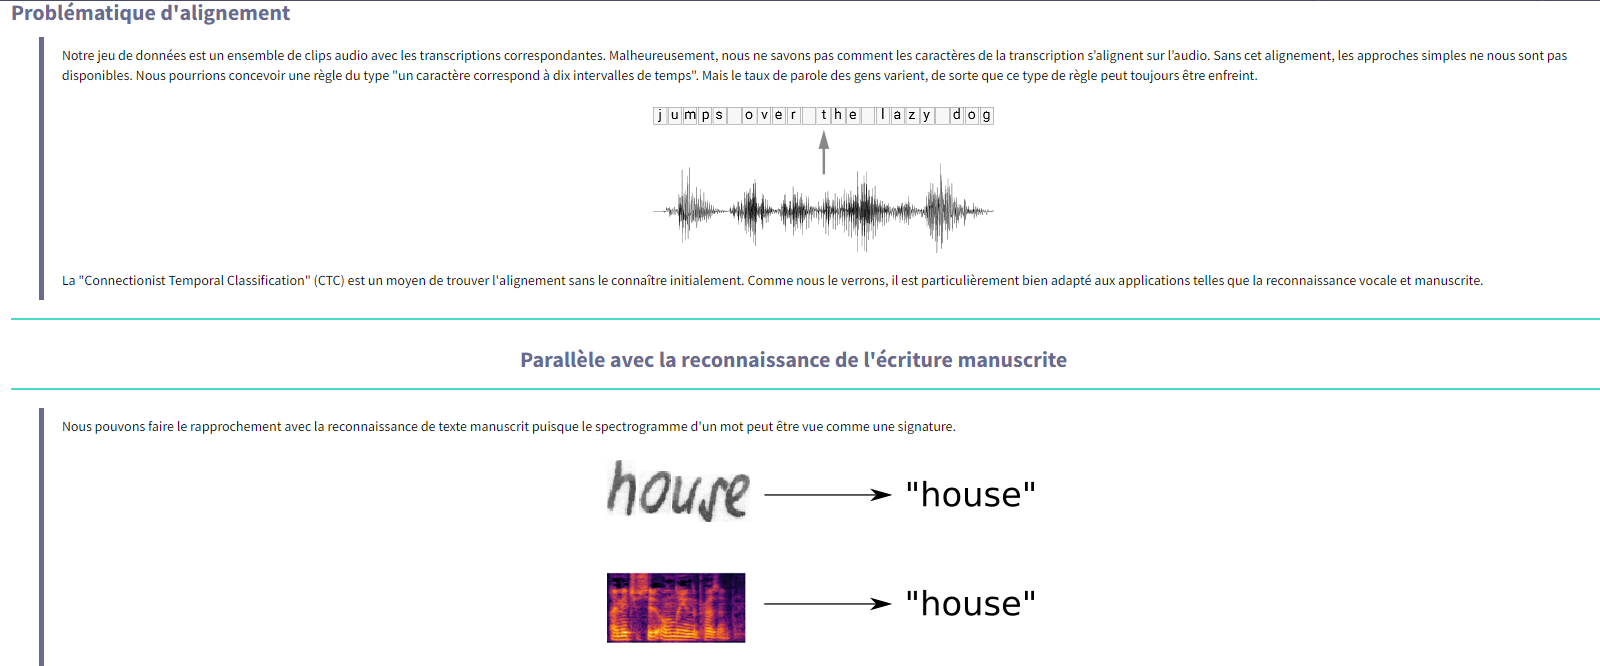

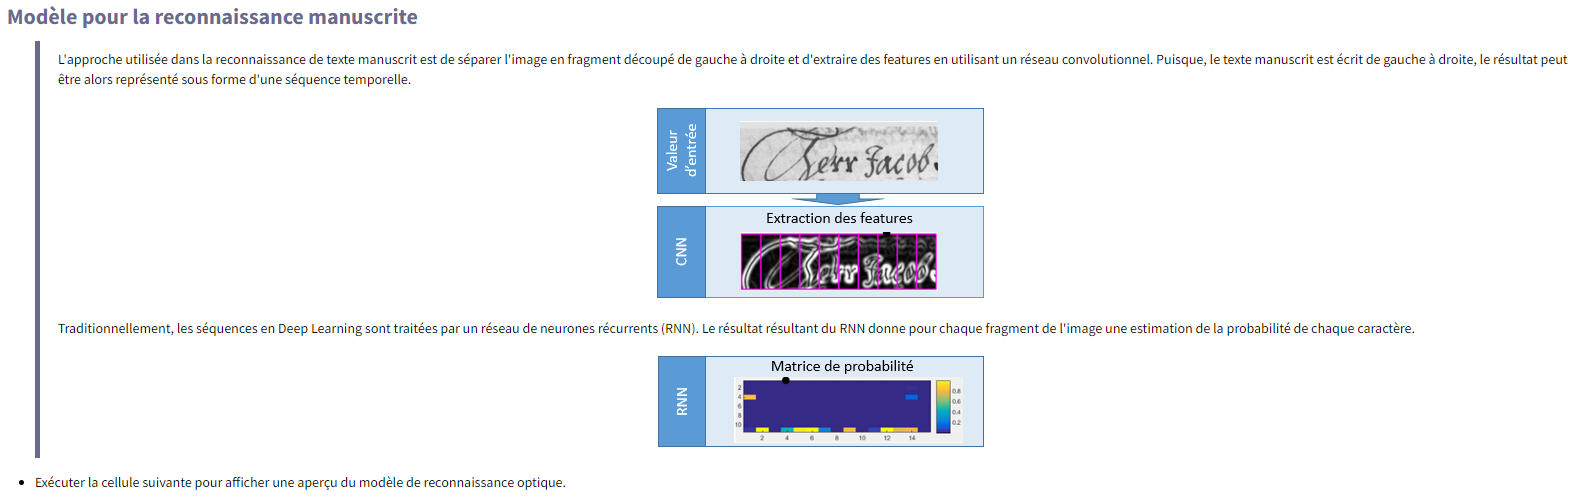

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, LeakyReLU, Lambda, Dense, Dropout
from tensorflow.keras.layers import GRU, Bidirectional
from keras.utils.vis_utils import plot_model
numHidden = 256
alphabet = ' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

model_ocr = tf.keras.Sequential()
# Convolution Part : Extraction Feature
# Layer 1
model_ocr.add(Conv2D(filters=32, kernel_size=(5,5), padding='SAME', input_shape = (128, 32, 1)))

model_ocr.add(BatchNormalization())
model_ocr.add(LeakyReLU())
model_ocr.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Layer 2
model_ocr.add(Conv2D(filters=64, kernel_size=(5,5), padding='SAME'))
model_ocr.add(BatchNormalization())
model_ocr.add(LeakyReLU())
model_ocr.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Layer 3
model_ocr.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
model_ocr.add(BatchNormalization())
model_ocr.add(LeakyReLU())
model_ocr.add(MaxPooling2D(pool_size=(1,2), strides=(1,2)))

# Layer 4
model_ocr.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
model_ocr.add(BatchNormalization())
model_ocr.add(LeakyReLU())
model_ocr.add(MaxPooling2D(pool_size=(1,2), strides=(1,2)))

# Layer 5
model_ocr.add(Conv2D(filters=256, kernel_size=(3,3), padding='SAME'))
model_ocr.add(BatchNormalization())
model_ocr.add(LeakyReLU())
model_ocr.add(MaxPooling2D(pool_size=(1,2), strides=(1,2)))


# Remove axis 2
model_ocr.add(Lambda(lambda x :tf.squeeze(x, axis=2)))

# Bidirectionnal RNN
model_ocr.add(Bidirectional(GRU(numHidden, return_sequences=True)))
# Classification of characters
model_ocr.add(Dense(len(alphabet)+1))

model_ocr.summary()

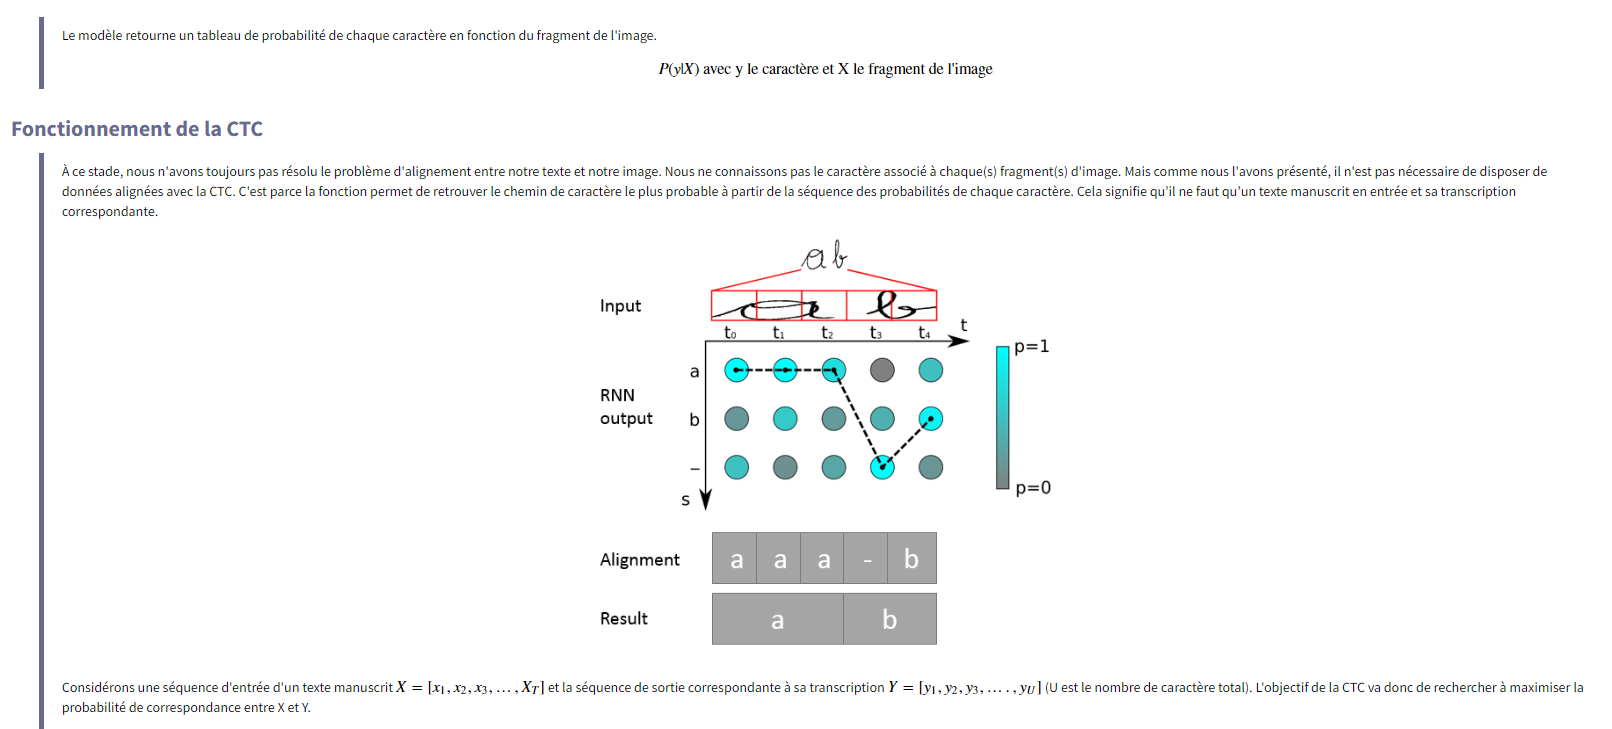

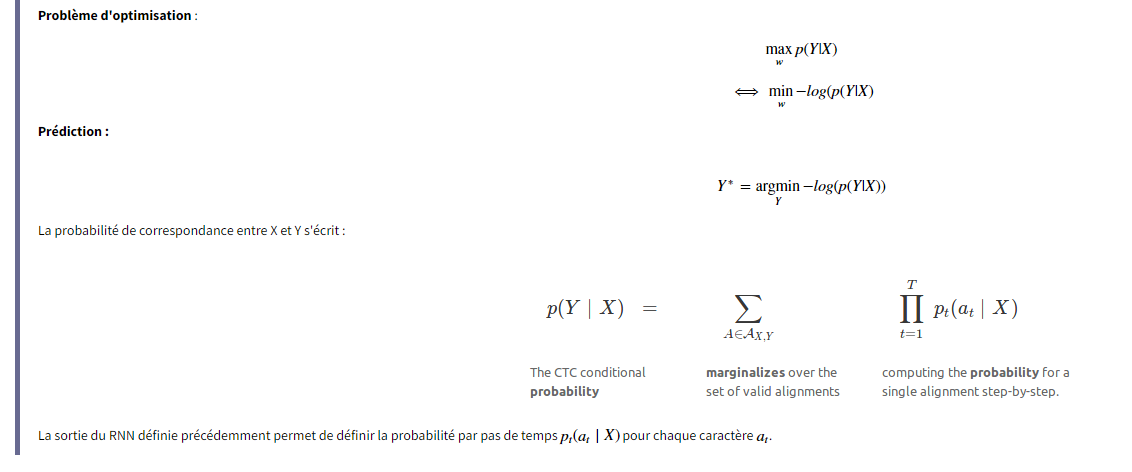

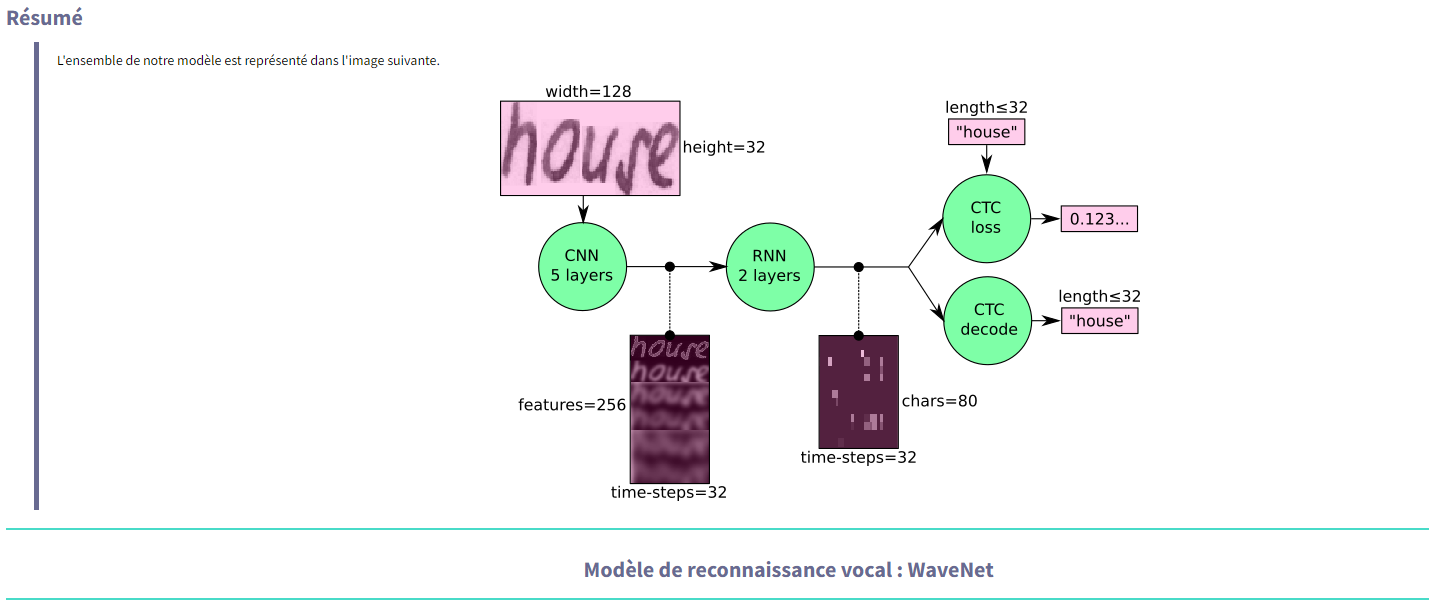

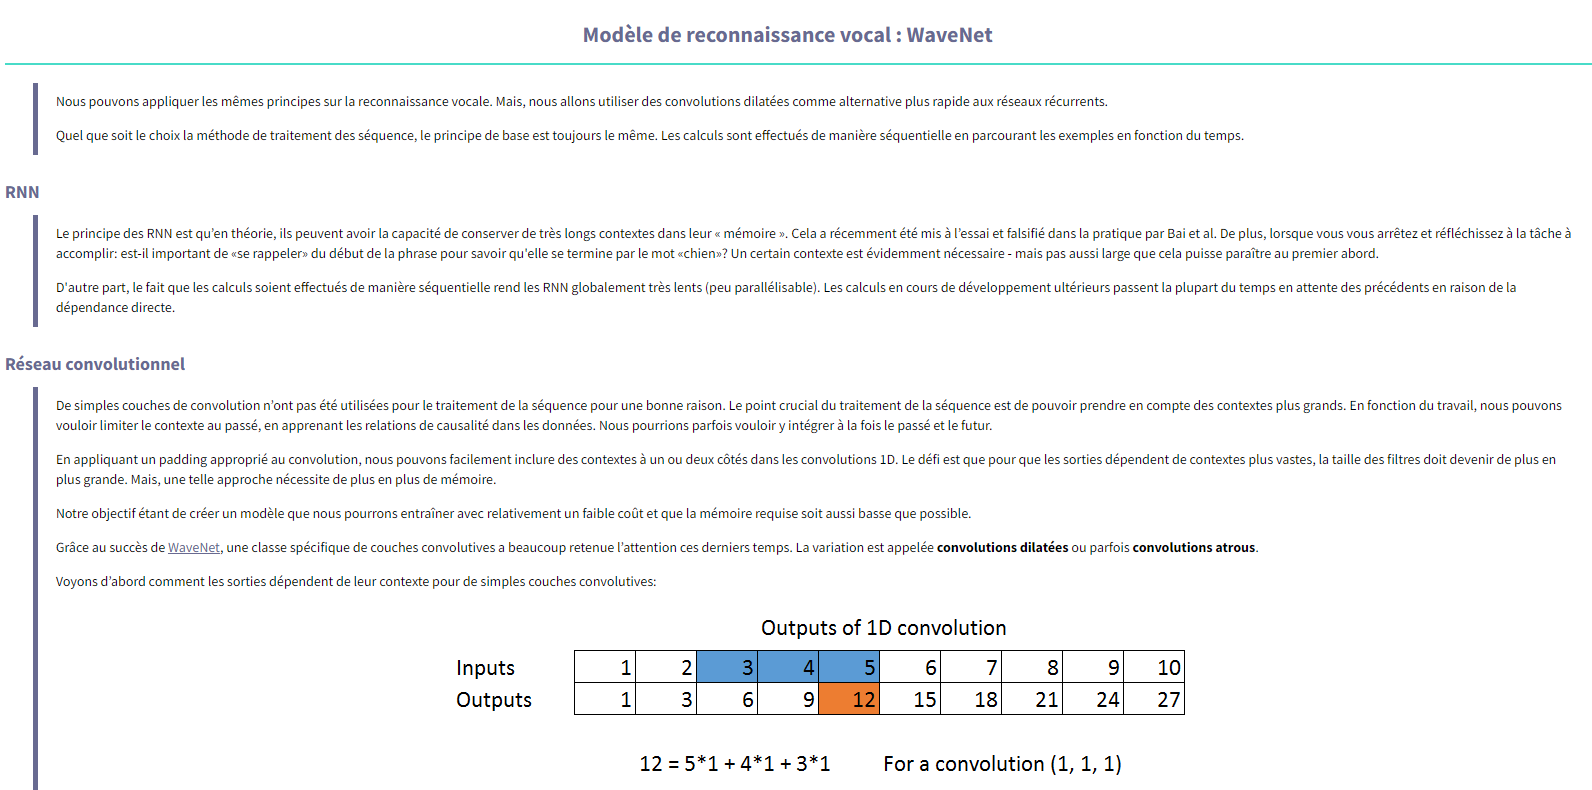

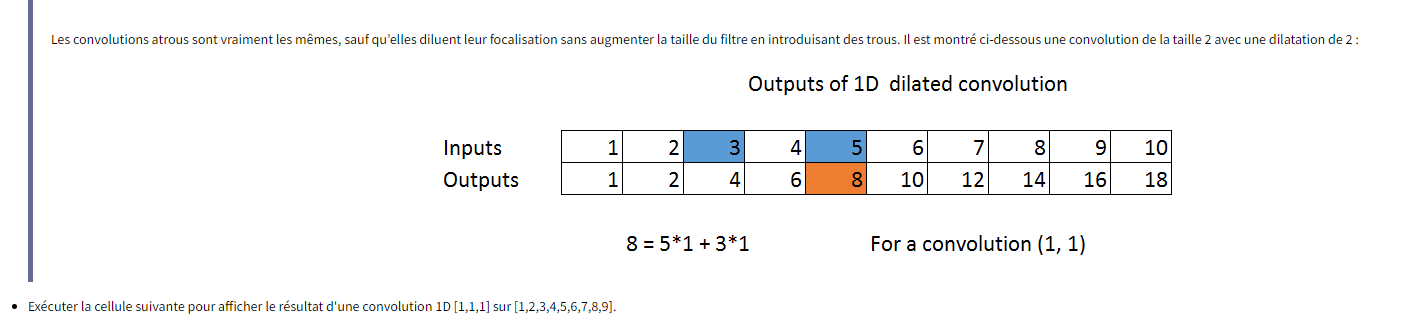

In [ ]:
import tensorflow as tf
import numpy as np
X = np.expand_dims(np.arange(11, dtype=float), -1)/1

layer_conv1d = tf.keras.layers.Conv1D(1, 2, padding='same', use_bias=False, dilation_rate=2)
layer_conv1d.build([1, 11, 1])
layer_conv1d.weights[0].assign(np.ones([2,1,1]))
with tf.device('/cpu:0'):
    y = layer_conv1d(np.array([X])).numpy()

print('Input :')
print(X, '\n')
print('Output :')
print(y)

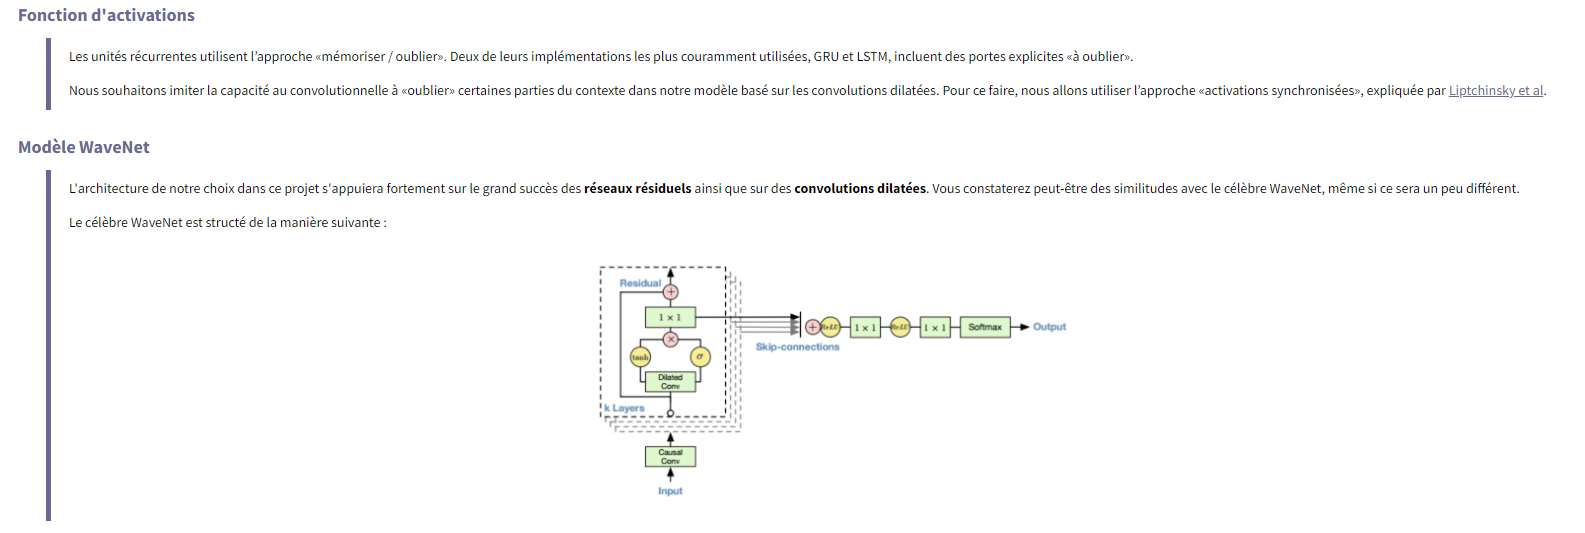

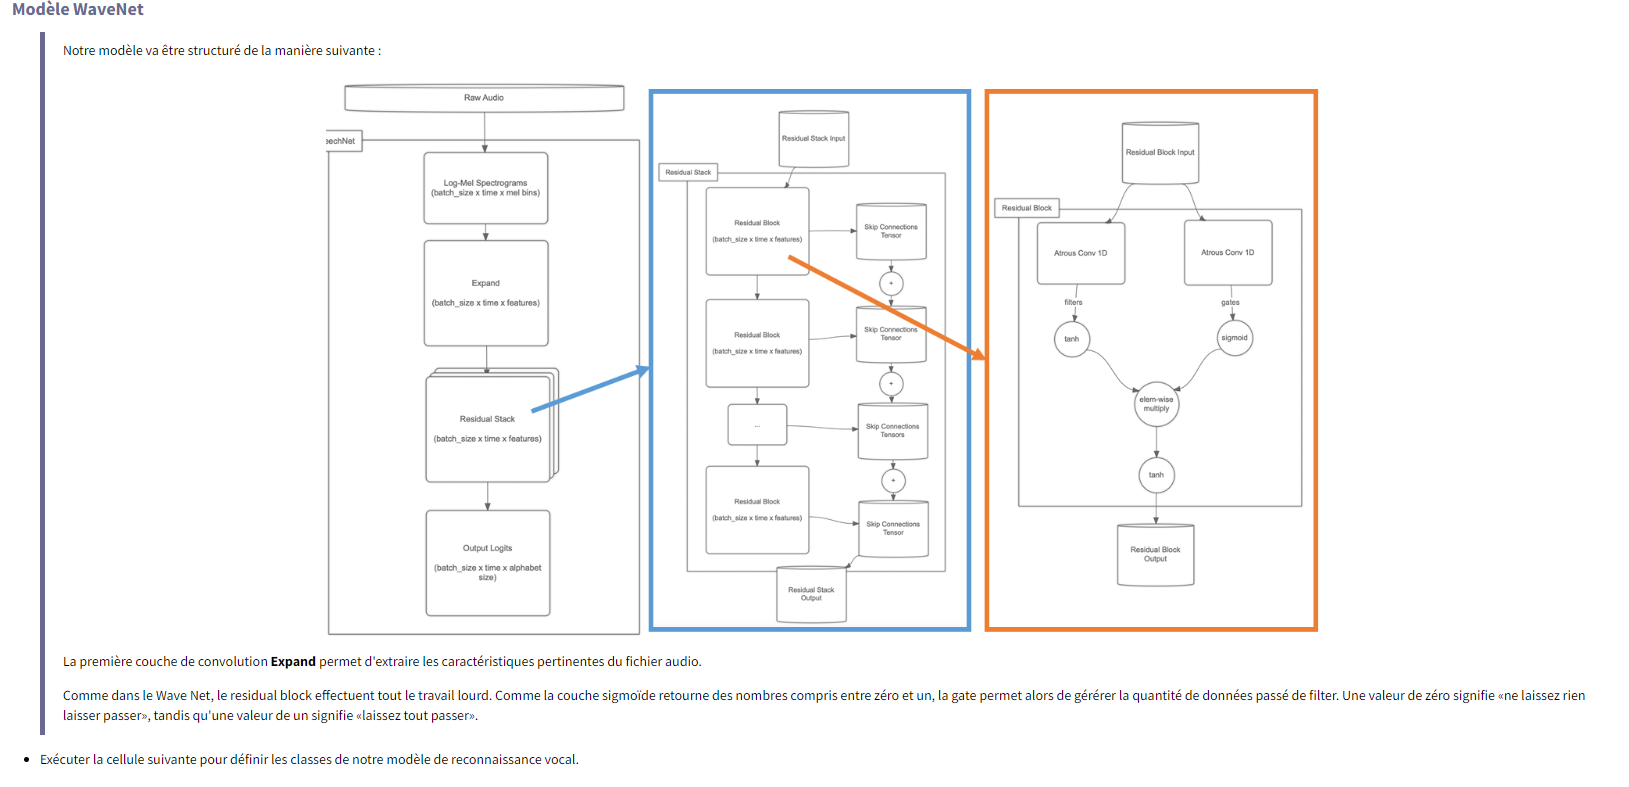

In [ ]:
class AtrousConv1D(tf.keras.layers.Layer):
    def __init__(self,
                 filters,
                 kernel_size,
                 dilation_rate,
                 use_bias=True,
                 kernel_initializer=tf.keras.initializers.GlorotNormal(),
                 causal=True
                ):
        super(AtrousConv1D, self).__init__()
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.causal = causal
        
        # Convolution with dilation
        self.conv1d = tf.keras.layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            padding='valid' if causal else 'same',
            use_bias=use_bias,
            kernel_initializer=kernel_initializer
        )
        
    def call(self, inputs):
        # If padding 'valid', the shape of tensor change.
        if self.causal:
            padding = (self.kernel_size - 1) * self.dilation_rate
            inputs = tf.pad(inputs, tf.constant([(0, 0,), (1, 0), (0, 0)]) * padding)
        
        return self.conv1d(inputs)
    
    
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate, causal, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        
        self.batch_normalization = tf.keras.layers.BatchNormalization()
        
        # First convolution of ResidualBloack
        self.dilated_conv1 = AtrousConv1D(
            filters=filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            causal=causal
        )
        
        # Second convolution of ResidualBloack
        self.dilated_conv2 = AtrousConv1D(
            filters=filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            causal=causal
        )
        
        self.out = tf.keras.layers.Conv1D(
            filters=filters,
            kernel_size=1
        )
        
    def call(self, inputs, training=True):
        # Normalization of data
        data = self.batch_normalization(
            inputs
        )
        # Dilated convolution filters
        filters = self.dilated_conv1(data)
        filters = tf.nn.tanh(filters)
        
        # Dilated convolution gates
        gates = self.dilated_conv2(data) 
        gates = tf.nn.sigmoid(gates)
        
        # Elem-wise multiply
        out = tf.nn.tanh(
            self.out(
                filters * gates
            )
        )
        
        return out + inputs, out
    
        
class ResidualStack(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rates, causal, **kwargs):
        super(ResidualStack, self).__init__(**kwargs)
        
        # Definition of all Residual Block
        self.blocks = [
            ResidualBlock(
                filters=filters,
                kernel_size=kernel_size,
                dilation_rate=dilation_rate,
                causal=causal
            )
            for dilation_rate in dilation_rates
        ]
        
    def call(self, inputs, training=True):
        data = inputs
        skip = 0
        
        for block in self.blocks:
            # Output of Residual Block
            data, current_skip = block(data, training=training)
            # add all each skip connection
            skip += current_skip

        return skip


class SpeechNet(tf.keras.Model):
    def __init__(self, params, **kwargs):
        super(SpeechNet, self).__init__(**kwargs)
        
        self.batchnormalization1 =tf.keras.layers.BatchNormalization()
        
        # Expand convolution: extract features
        self.expand = tf.keras.layers.Conv1D(
            filters = params['stack_filters'],
            kernel_size=1,
            padding='same'
        )
        # Definition of all Residual Stack
        self.stacks = [
            ResidualStack(
                filters=params['stack_filters'],
                kernel_size=params['stack_kernel_size'],
                dilation_rates=params['stack_dilation_rates'],
                causal=params['causal_convolutions']
            )
            for _ in range(params['stacks'])
        ]
        # Definition of the last convolution
        self.out = tf.keras.layers.Conv1D(
            filters=len(params['alphabet']) + 1,
            kernel_size=1,
            padding='same'
        )
        
        self.batchnormalization2 = tf.keras.layers.BatchNormalization()
        
    def call(self, inputs, training=True):
        # Data Normalization
        data = self.batchnormalization1(
            inputs
        )
        
        # Right shape for convolution.
        if len(data.shape) == 2:
            data = tf.expand_dims(data, 0)
            
        # Extract features    
        data = self.expand(data)
        
        # Residual Stack
        for stack in self.stacks:
            data = stack(data, training=training)
        
        # Data Normalization
        data = self.batchnormalization2(
            data
        )
        
        return self.out(data) + 1e-8

In [ ]:
Exécuter la cellule suivante pour définir notre modèle de reconnaissance vocal.

In [ ]:
params = {
    'max_wave_length': 20,
    'alphabet': ' !"&\',-.01234:;\\abcdefghijklmnopqrstuvwxyz',
    'causal_convolutions': False,
    'stack_dilation_rates': [1, 3, 9, 27],
    'stacks': 6,
    'stack_kernel_size': 7,
    'stack_filters': 3*128,
    'sampling_rate': 16000,
    'n_fft': 160*8,
    'frame_step': 160*4,
    'lower_edge_hertz': 0,
    'upper_edge_hertz': 8000,
    'num_mel_bins': 160
}

model = SpeechNet(params)
number_exploited_data = params['max_wave_length']*params['sampling_rate']-params['n_fft']
lengths = int(number_exploited_data/params['frame_step']+1)
model(np.random.uniform(size=[1, lengths, params['num_mel_bins']]))
model.load_weights('model/model.h5')

À l'aide de la fonction load_wave charger les dix premiers fichiers audio dans la variable X.

Charger la transcription correspondante dans la variable y.

In [ ]:
def load_wave(path_audio, params):
    # Load audio
    wave, fe = load_audio(path_audio)
    # Return None for a too long file
    if len(wave) > params['max_wave_length']*fe:
        print('Shape invalid')
        return None
   
    # After this transformation add zeroes to have the right shape
    else :
        return np.concatenate([wave, np.zeros(params['max_wave_length']*fe - len(wave))])
    
X_audio = [load_wave(p, params) for p in df.audio_path[:10]]
y = df.text[:10]

Mettre les fichiers audios X_audio sous la forme d'un tableau array de log mel spectrogramme dans la variable X.

In [ ]:
fe = 16000
X = np.array([logMelSpectrogram(audio, params, fe) for audio in X_audio])

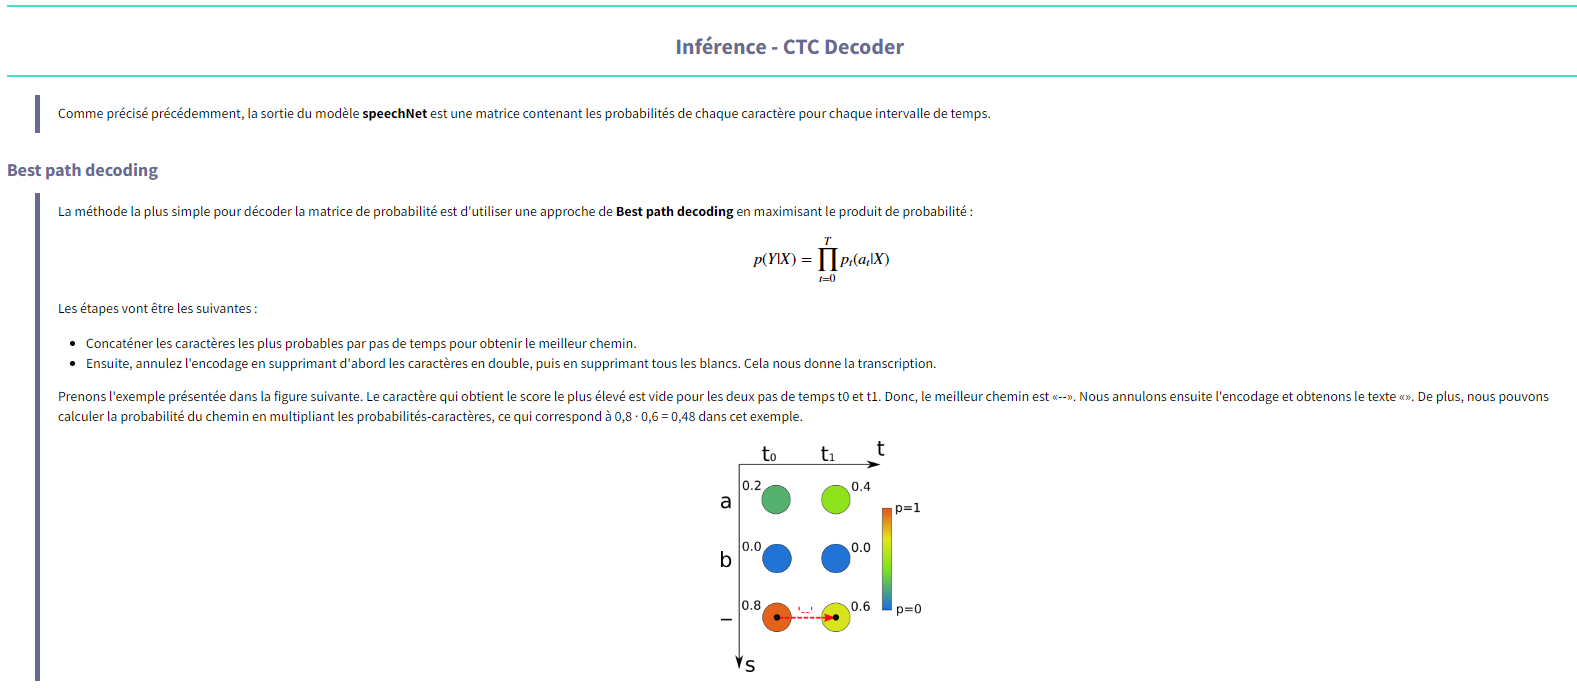

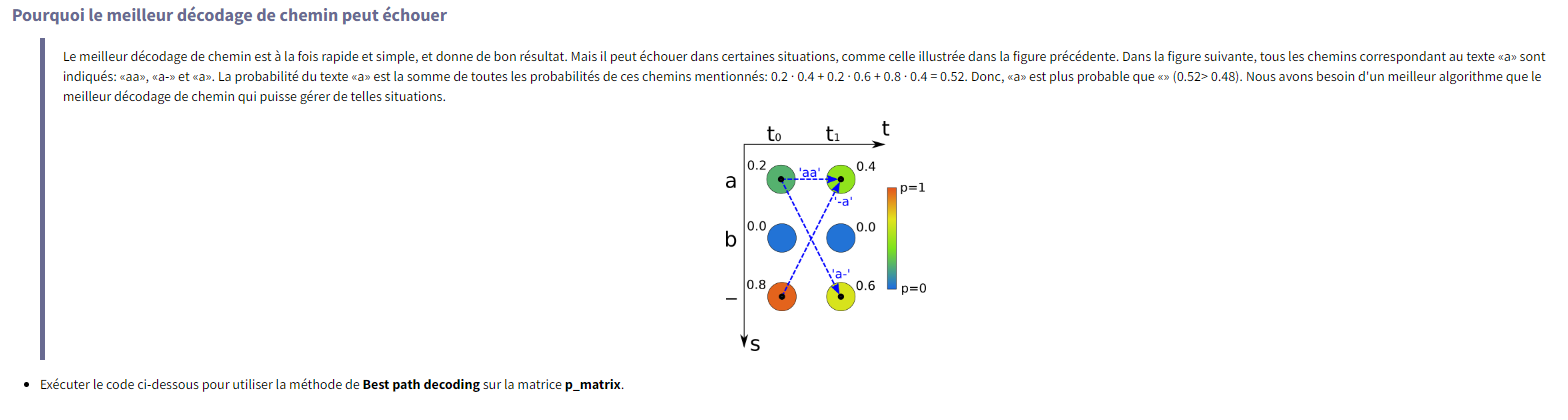

In [ ]:
p_matrix = np.array(
        [[0.3, 0.1, 0.05, 0.05, 0.5],
        [0.5, 0.05, 0.05, 0.1, 0.3],
        [0.3, 0.1, 0.05, 0.05, 0.5],
        [0.5, 0.05, 0.05, 0.1, 0.3],
        [0.3, 0.1, 0.05, 0.05, 0.5],
        [0.5, 0.05, 0.05, 0.1, 0.3],
        [0.3, 0.1, 0.05, 0.05, 0.5],
        [0.5, 0.05, 0.05, 0.1, 0.3],
        [0.3, 0.1, 0.05, 0.05, 0.5],
        [0.5, 0.05, 0.05, 0.1, 0.3]])

print('Transpose probabilty matrix')
print(p_matrix.T)
# Example of greedy_decoder
def greedy_decoder(data):
    # index for largest probability each row
    return [np.argmax(s) for s in data]

greedy_decoder(p_matrix)

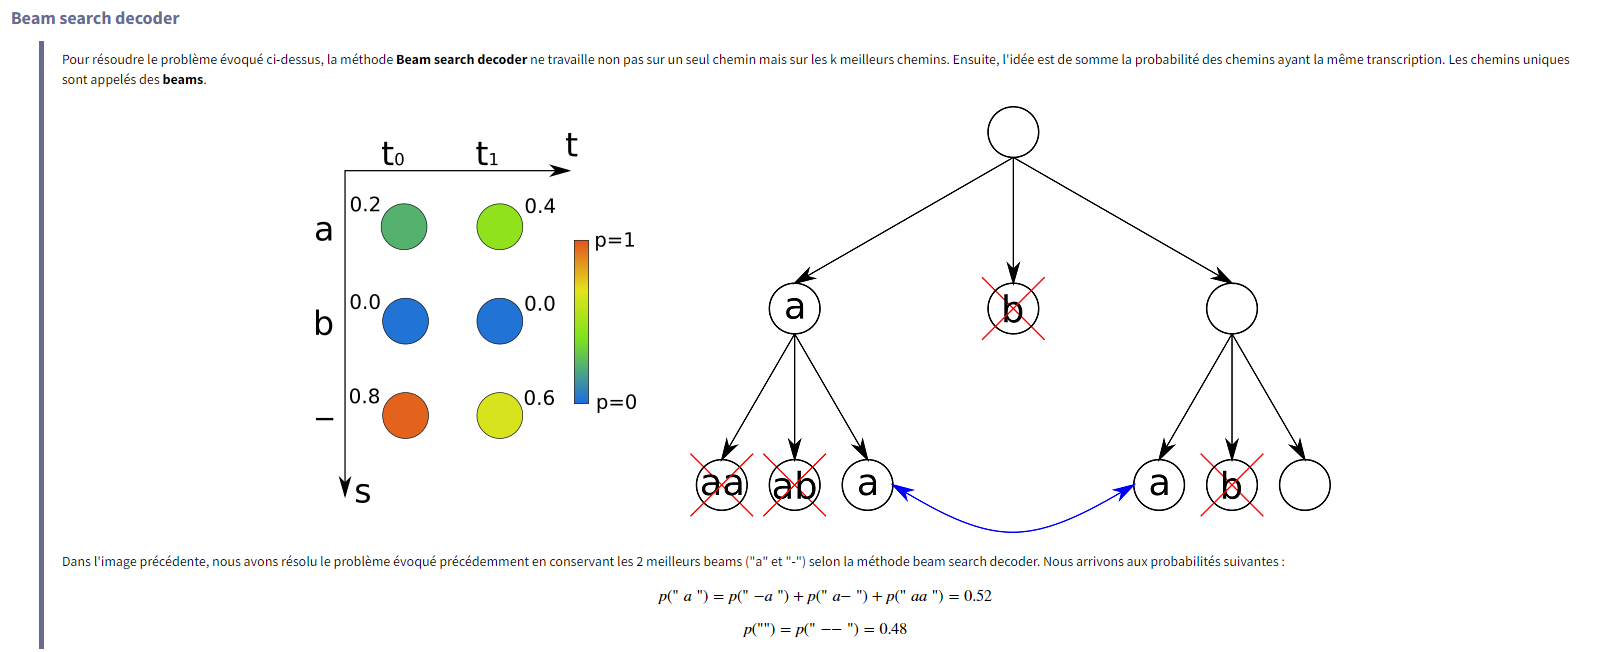

In [ ]:
Exécuter la cellule suivante pour trouver les k chemins les plus probable de la matrice de probabilité p_matrix.

In [ ]:
# Example of beam search decoder
def beam_search_decoder(data, k):
    sequences = [[list(), 1.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                candidate = [seq + [j], score * row[j]]
                all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[1], reverse=True)
        # select k best
        sequences = ordered[:k]
    return sequences
 

print(p_matrix.T)


# decode sequence
result = beam_search_decoder(p_matrix, 3)

# print result
for seq in result:
    print(seq)

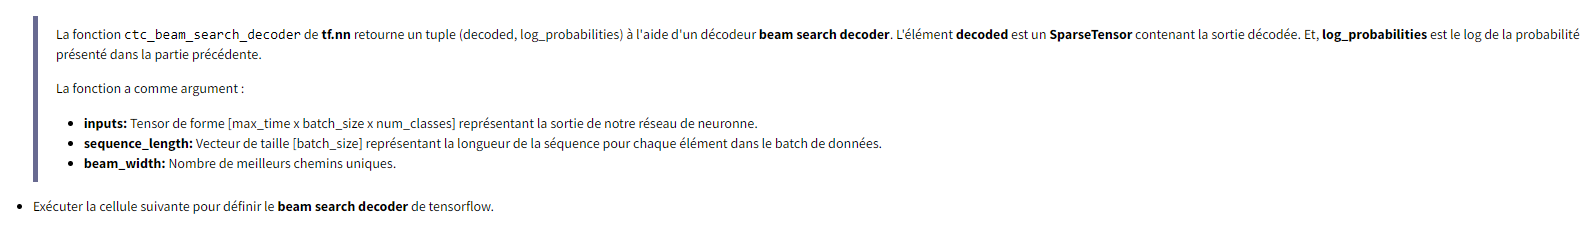

In [ ]:
def decode_codes(codes, charList):
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            np.arange(len(charList)),
            charList,
            key_dtype=tf.int32
        ),
        '',
        name='id2char'
    )
    return table.lookup(codes)

def greedy_decoder(logits, params):
    # ctc beam search decoder
    predicted_codes, _ = tf.nn.ctc_beam_search_decoder(
        inputs = tf.transpose(logits, (1, 0, 2)),
        sequence_length = [logits.shape[1]]*logits.shape[0],
        beam_width = 100,
        top_paths = 1
    )
    # convert to int32
    codes = tf.cast(predicted_codes[0], tf.int32)
    
    # Decode the index of caracter
    text = decode_codes(codes, list(params['alphabet']))
    
    # Convert a SparseTensor to string
    text = tf.sparse.to_dense(text).numpy().astype(str)
    
    return list(map(lambda x: ''.join(x), text))

## Résultat
Dans les parties précédentes, nous avons entraîné notre modèle. Nous allons maintenant rechercher à afficher la transcription d'un fichier audio.

Exécuter la cellule suivante pour afficher le transcription optenu par notre modèle sur les dix premiers fichiers audios.

In [ ]:
y_logit = model(X)
transcriptions = greedy_decoder(y_logit, params)
transcriptions

Afficher la prédiction et la vrai transcription du premier fichier audio de X_audio.
Écouter le fichier audio l'aide de la fonction Audio.

In [ ]:
sample_id = 0
print('Prediction :\n', transcriptions[sample_id], '\n')
print('Real Transcription :\n', y[sample_id])
Audio(X_audio[sample_id], rate=fe)

In [ ]:
Pour aller plus loin : Correction de langage / Modèle de langage